In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import math

data = pd.read_csv('data/data.csv')
data = data.drop(columns=['Latitude', 'Longitude', 'Urban Population', 'Total Population', 'Mortality Rate', 'Mean temperature', 'Climate'])

### Clipping the time series
From the previous plots, we can see that the cumulative time series of confirmed cases is not always well suited for linear or exponential regression : some countries have curves that alternate between growth and stagnation phases.

The reason for this is probably that a lot of countries have implemented measures to slow down the spread of the COVID-19 and this means that the natural spread rate that we are trying to capture is not visible in every part of the time series.

To solve this problem, we can clip the time series to only keep the part where the derivative of the time series is the highest.

#### Plotting the second derivative of the confirmed cases

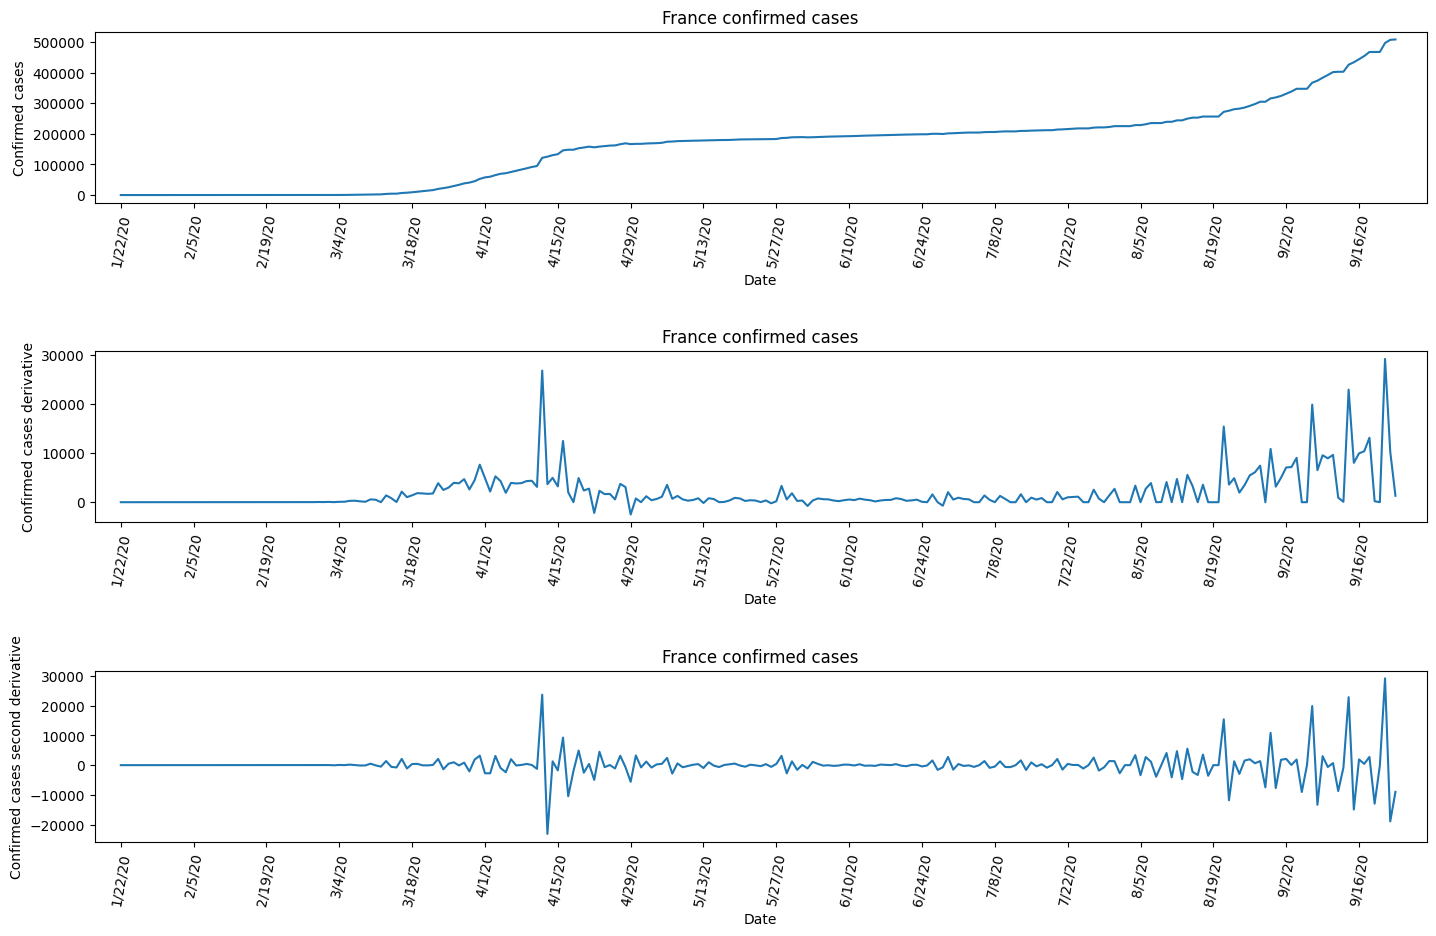

In [98]:
country = 'France'

fig, axs = plt.subplots(3, 1, figsize=(15, 10))

country_data = data[data['Country'] == country]
country_data = country_data.drop(columns=['Country'])

x = country_data.columns
y = country_data.values[0]

d1 = [y[i] - y[i-1] if i > 0 else 0 for i in range(len(y))]
d2 = [d1[i] - d1[i-1] if i > 0 else 0 for i in range(len(d1))]

for i, d in enumerate([y, d1, d2]):
    axs[i].plot(x, d)
    axs[i].set_title(f'{country} confirmed cases')
    axs[i].set_xlim(-5, len(x) + 5)
    axs[i].set_xlabel('Date')
    axs[i].tick_params(axis='x', rotation=80)
    axs[i].xaxis.set_major_locator(plt.MultipleLocator(14))

axs[0].set_ylabel('Confirmed cases')
axs[1].set_ylabel('Confirmed cases derivative')
axs[2].set_ylabel('Confirmed cases second derivative')
fig.tight_layout(pad=3.0)
plt.show()

#### Polynomial regression
The derivatives computed from the time series are very noisy, so we'll use polynomial regression to smoothe the time series and then compute the derivatives.

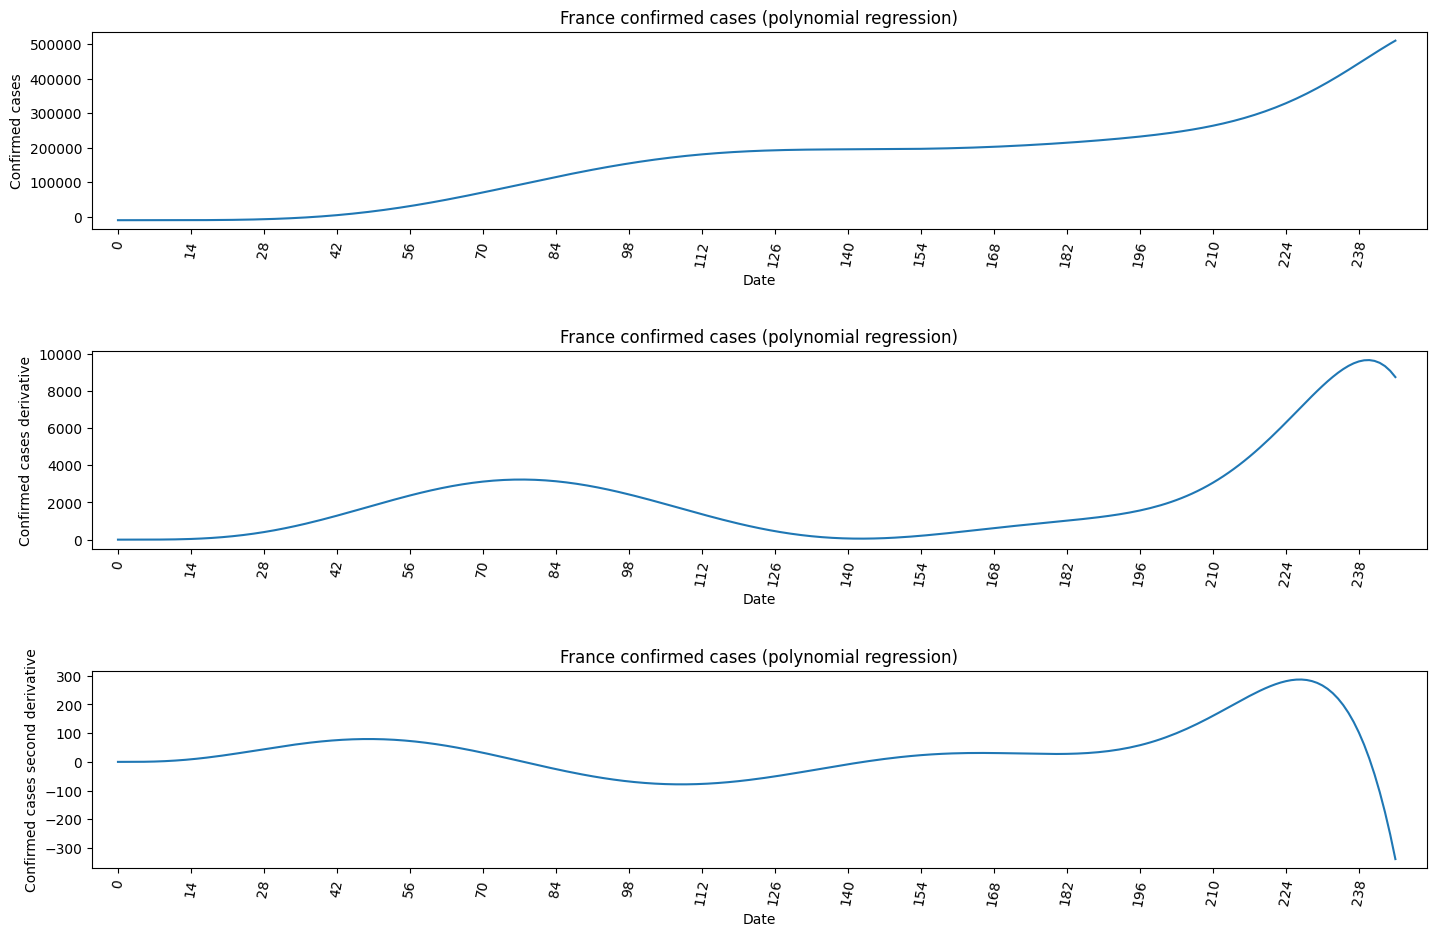

In [99]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


country = 'France'
degree = 10

fig, axs = plt.subplots(3, 1, figsize=(15, 10))

country_data = data[data['Country'] == country]
country_data = country_data.drop(columns=['Country'])

x = range(len(country_data.columns))
y = country_data.values[0]

poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform([[i] for i in x])
model = LinearRegression()
model.fit(X_poly, y)

y_poly = model.predict(X_poly)
d1_poly = [y_poly[i] - y_poly[i-1] if i > 0 else 0 for i in range(len(y_poly))]
d2_poly = [d1_poly[i] - d1_poly[i-1] if i > 0 else 0 for i in range(len(d1_poly))]

for i, d in enumerate([y_poly, d1_poly, d2_poly]):
    axs[i].plot(x, d)
    axs[i].set_title(f'{country} confirmed cases (polynomial regression)')
    axs[i].set_xlim(-5, len(x) + 5)
    axs[i].set_xlabel('Date')
    axs[i].tick_params(axis='x', rotation=80)
    axs[i].xaxis.set_major_locator(plt.MultipleLocator(14))

axs[0].set_ylabel('Confirmed cases')
axs[1].set_ylabel('Confirmed cases derivative')
axs[2].set_ylabel('Confirmed cases second derivative')
fig.tight_layout(pad=3.0)
plt.show()

#### Moving average
We can also try smoothing the time series with a moving average to compare the results with the polynomial regression.

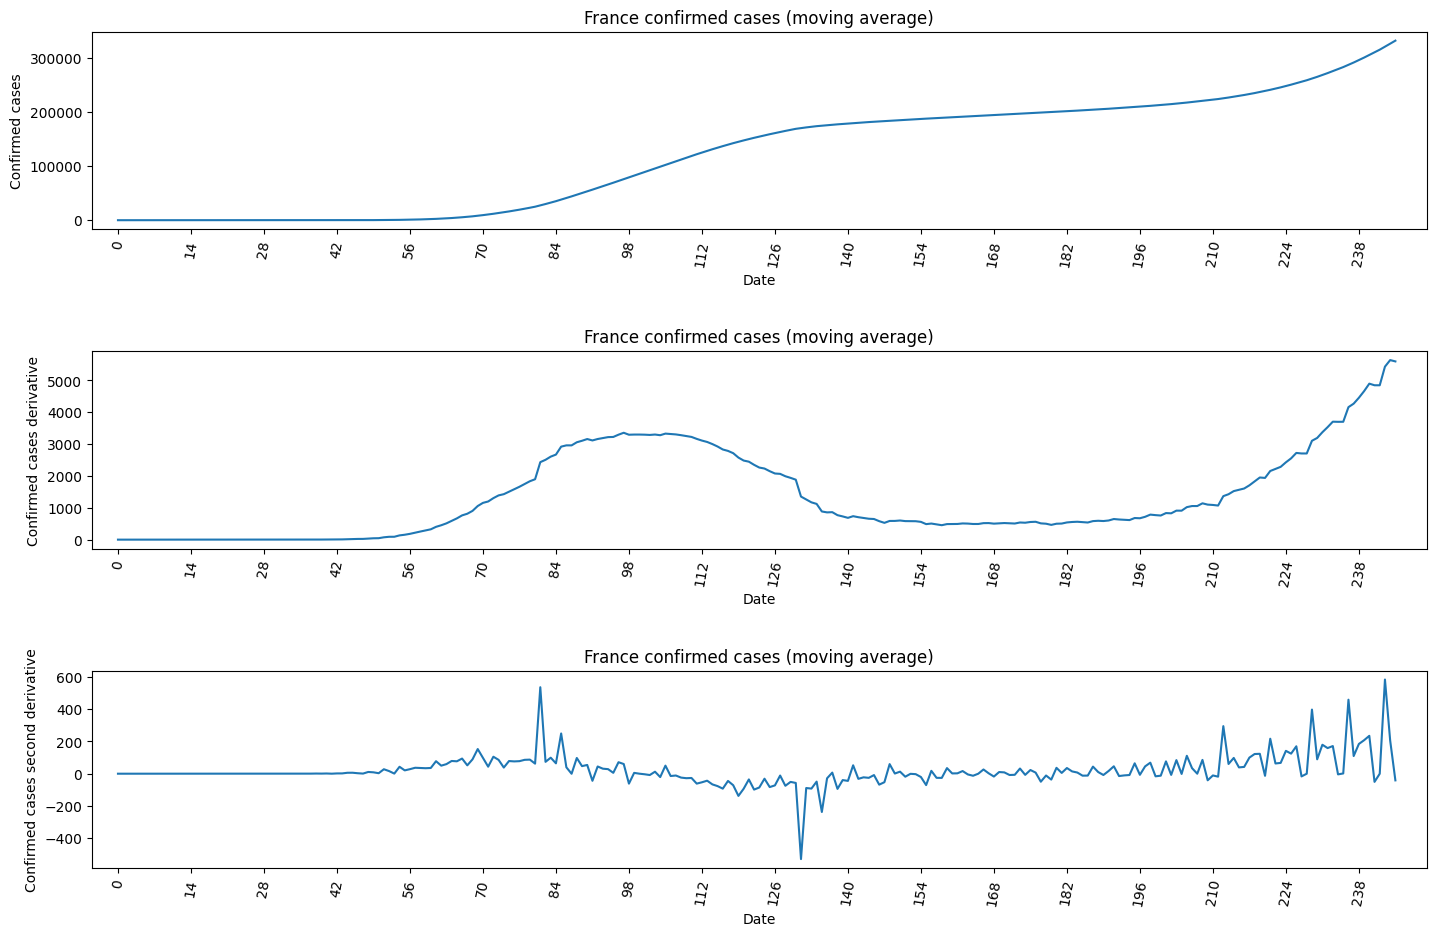

In [100]:
def moving_average(data, window):
    # Dont pad with zeros, just use the mean of the first window elements
    s = pd.Series(data).rolling(window=window, min_periods=1).mean()
    s.fillna(data[:window].mean(), inplace=True)
    return s

country = 'France'
window = 50

fig, axs = plt.subplots(3, 1, figsize=(15, 10))

country_data = data[data['Country'] == country]
country_data = country_data.drop(columns=['Country'])

x = range(len(country_data.columns))
y = country_data.values[0]

y_smooth = moving_average(y, window)
d1_smooth = [y_smooth[i] - y_smooth[i-1] if i > 0 else 0 for i in range(len(y_smooth))]
d2_smooth = [d1_smooth[i] - d1_smooth[i-1] if i > 0 else 0 for i in range(len(d1_smooth))]

for i, d in enumerate([y_smooth, d1_smooth, d2_smooth]):
    axs[i].plot(x, d)
    axs[i].set_title(f'{country} confirmed cases (moving average)')
    axs[i].set_xlim(-5, len(x) + 5)
    axs[i].set_xlabel('Date')
    axs[i].tick_params(axis='x', rotation=80)
    axs[i].xaxis.set_major_locator(plt.MultipleLocator(14))

axs[0].set_ylabel('Confirmed cases')
axs[1].set_ylabel('Confirmed cases derivative')
axs[2].set_ylabel('Confirmed cases second derivative')
fig.tight_layout(pad=3.0)
plt.show()

The results seems better for the moving average, so we'll use it to clip the time series.

#### Rupture detection
We can use the `ruptures` library to automatically detect ruptures in the time series and clip it accordingly.

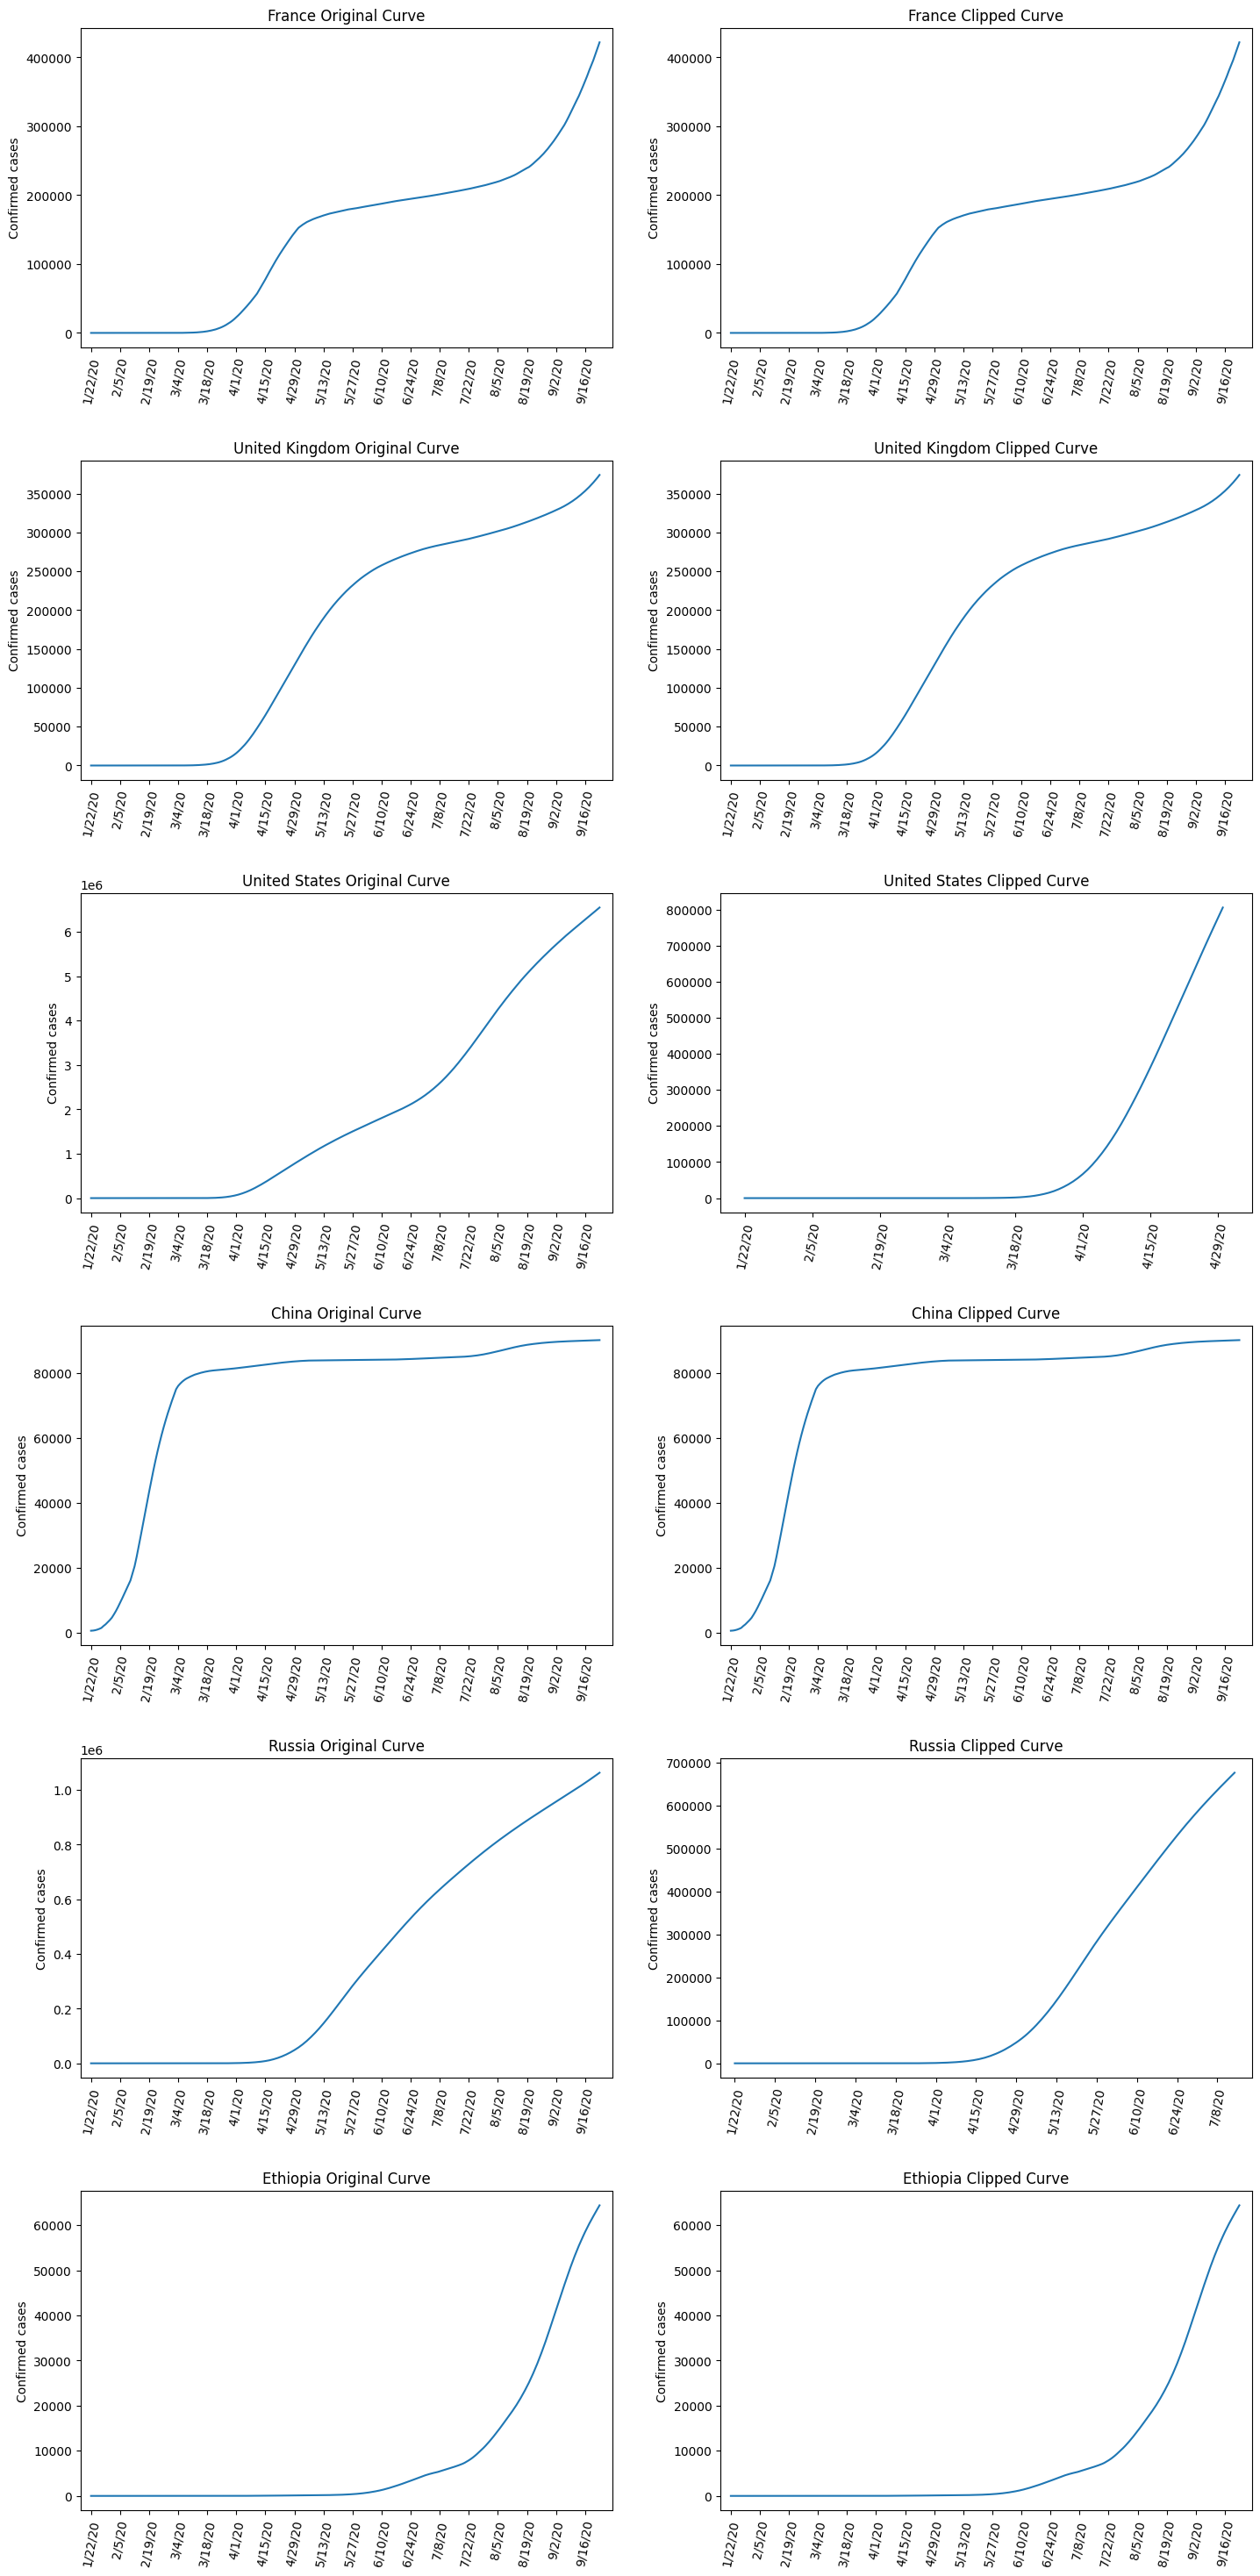

In [101]:
import matplotlib.pyplot as plt
import ruptures as rpt
import numpy as np


def clip_rupture(country_data, penalty=10):
    country_data = np.array(country_data).reshape(-1, 1)
    algo = rpt.Pelt(model="l2").fit(country_data)
    change_points = algo.predict(pen=penalty)
    if len(change_points) > 1:
        return country_data[:change_points[1]]
    return country_data[:change_points[0]]

countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']
n = len(countries)
x = data.columns[1:]

fig, axs = plt.subplots(n, 2, figsize=(15, 5 * n))

for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country']).values[0]
    country_data_smooth = moving_average(country_data, 20)
    axs[i, 0].plot(x, country_data_smooth)
    axs[i, 0].set_title(f'{country} Original Curve')
    axs[i, 0].set_ylabel('Confirmed cases')
    axs[i, 0].set_xlim(-5, len(x) + 5)
    axs[i, 0].tick_params(axis='x', rotation=80)
    axs[i, 0].xaxis.set_major_locator(plt.MultipleLocator(14))


    clipped_data = clip_rupture(country_data_smooth, penalty=1e12)
    axs[i, 1].plot(x[:len(clipped_data)], clipped_data)
    axs[i, 1].set_title(f'{country} Clipped Curve')
    axs[i, 1].set_ylabel('Confirmed cases')
    axs[i, 1].set_xlim(-5, len(clipped_data) + 5)
    axs[i, 1].tick_params(axis='x', rotation=80)
    axs[i, 1].xaxis.set_major_locator(plt.MultipleLocator(14))

plt.tight_layout(pad=3.0)
plt.show()


We can't seem to find a good set of smoothing and clipping parameters that work for every country, so we'll try a different approach.